In [1]:
import numpy as np
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
print("all assets imported")

all assets imported


In [12]:
import numpy as np

class LogisticRegressionScratch:
    def __init__(self, lr=0.1, n_iter=2000, l2=0.0, batch_size=None, tol=1e-6, verbose=False):

        #learning rate is in float
        self.lr = float(lr)

        #number of iterations is in integer
        self.n_iter = int(n_iter)

        # L2 regularization strength is in float
        #l2 regularization helps to prevent overfitting by penalizing large weights
        self.l2 = float(l2)

        # batch size can be None (full-batch) or integer (mini-batch)
        # if None, full-batch gradient descent is used
        self.batch_size = batch_size 

        #tolerance for early stopping is in float
        #why early stopping? to prevent overfitting and save computation time
        self.tol = float(tol)

        #verbose is boolean to control printing of loss during training
        #why verbose? to monitor training progressself.verbose = bool(verbose)
        self.verbose = bool(verbose)

        # initialize weights and bias
        self.w = None
        self.b = 0.0

        # to store loss history
        self.loss_history = []


    #@staticmethod decorator indicates that this method does not depend on the instance
    # it can be called on the class itself
    @staticmethod

    #defining sigmoid function
    def _sigmoid(z):

        #cliping the values of z to prevent overflow in exp
        z = np.clip(z, -500, 500) 

        #returning the sigmoid of z notice we used 1.0 to ensure float division
        return 1.0 / (1.0 + np.exp(-z))


    #defining loss function (log loss with L2 regularization)
    def _loss(self, y_hat, y):

        #epsilon to prevent log(0) which is undefined
        eps = 1e-15

        #clipping predicted probabilities to avoid log(0) which is undefined
        y_hat = np.clip(y_hat, eps, 1 - eps)

        #base log loss calculation
        base = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

        #adding L2 regularization term if l2 > 0
        # this penalizes large weights to prevent overfitting
        #how? by adding the squared weights to the loss
        #when we add squared weights, larger weights increase the loss more
        #thus discouraging the model from relying too heavily on any single feature
        # dividing by 2*m normalizes the penalty

        if self.l2 > 0:
            base += (self.l2 / (2 * y.shape[0])) * np.sum(self.w * self.w)

            #returning the final loss value
        return base


    #defining the fit method to train the model
    def fit(self, X, y):

        #converting X and y to numpy arrays of type float64
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).ravel()  
        
        #number of samples (m) and features (n)
        m, n = X.shape

        #initialize weights to zeros and bias to 0.0
        self.w = np.zeros(n, dtype=np.float64)
        self.b = 0.0
        self.loss_history = []


        #determine batch size
        bs = self.batch_size if self.batch_size is not None else m
        
        #previous loss for early stopping
        prev_loss = np.inf

        #training loop
        for i in range(self.n_iter):

            # shuffle for mini-batch
            idx = np.random.permutation(m)

            # select shuffled data
            Xs = X[idx]
            ys = y[idx]


            # mini-batch gradient descent
            #here m is total number of samples
            # bs is batch size

            for start in range(0, m, bs):

                #selecting a mini batch
                # xb and yb are the mini-batch samples and labels and Xs and ys are the shuffled data
                #explaining the slicing:
                # start is the starting index of the current batch
                # start + bs is the ending index of the current batch
                # Xs[start:start + bs] selects the rows from start to start + bs
                # this gives us a mini-batch of size bs (or smaller for the last batch
                #same logic applies to yb

                xb = Xs[start:start + bs]
                yb = ys[start:start + bs]
                

                # forward pass
                #z is the linear combination of inputs and weights plus bias
                # y_hat is the predicted probability after applying sigmoid
                z = xb @ self.w + self.b
                y_hat = self._sigmoid(z)
                
                # compute gradients (vectorized)
                # err is the error between predicted and actual labels
                # dw is the gradient w.r.t weights
                #dw = xb mutliplied with ther error and then averaged over the batch size
                # db is the gradient w.r.t bias

                
                err = (y_hat - yb)  # (bs,)
                dw = (xb.T @ err) / xb.shape[0]
                db = np.mean(err)


                # add L2 regularization to weight gradient if l2 > 0
                # this adds the derivative of the L2 term to the weight gradient

                if self.l2 > 0:
                    dw += (self.l2 / xb.shape[0]) * self.w


                # update weights and bias

                self.w -= self.lr * dw
                self.b -= self.lr * db

            # track loss once per epoch 
            # y_hat_all are the predictions for the entire dataset
            # loss is computed for the entire dataset
            # appending loss to loss history

            y_hat_all = self._sigmoid(X @ self.w + self.b)
            loss = self._loss(y_hat_all, y)
            self.loss_history.append(loss)



            # print loss if verbose is True
            # this helps in monitoring the training process

            if self.verbose and (i % 100 == 0 or i == self.n_iter - 1):
                print(f"iter={i}, loss={loss:.6f}")

            # early stopping
            #if the change in loss is less than tolerance, stop training
            #this prevents overfitting and saves computation time

            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

        return self
     #defining method to predict probabilities
     # given input features X, this method returns the predicted probabilities
     #predict_proba method uses the learned weights and bias to compute probabilities
     #then applies the sigmoid function of the linear combination of inputs and weights plus bias
     # it returns values between 0 and 1 representing probabilities
     #then prredict method uses predict_proba to get probabilities
    # and applies a threshold to convert probabilities into binary class labels (0 or 1)
    
    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        return self._sigmoid(X @ self.w + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [13]:
import pandas as pd
df = pd.read_csv("breast-cancer.csv")
df = df.copy()
print(df.head())

if 'id' in df.columns:
    df = df.drop(columns = ['id'])

df['diagnosis'] = df['diagnosis'].map({ 'M': 1, 'B': 0})

X = df.drop(columns= ['diagnosis'])
y = df['diagnosis']



         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size= 0.25, shuffle= True
)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure labels are 1D numpy arrays
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [15]:
print(X_train_scaled.shape, X_test_scaled.shape)

model = LogisticRegressionScratch(
    lr=0.1,
    n_iter=3000,
    l2=0.1,
    batch_size=64,   # try 32, 64, 128
    tol=1e-7,
    verbose=True
)

model.fit(X_train_scaled, y_train_np)

pred = model.predict(X_test_scaled)
accuracy = np.mean(pred == y_test_np)
print(f"Model Accuracy: {accuracy:.4f}")




(426, 30) (143, 30)
iter=0, loss=0.285497
iter=100, loss=0.069934
iter=200, loss=0.062941
iter=300, loss=0.059905
iter=400, loss=0.058249
iter=500, loss=0.057178
iter=600, loss=0.056473
Model Accuracy: 0.9790


In [19]:
# Make plots prettier (global styling)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk", palette="deep")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.grid": True,
    "grid.alpha": 0.25,
})

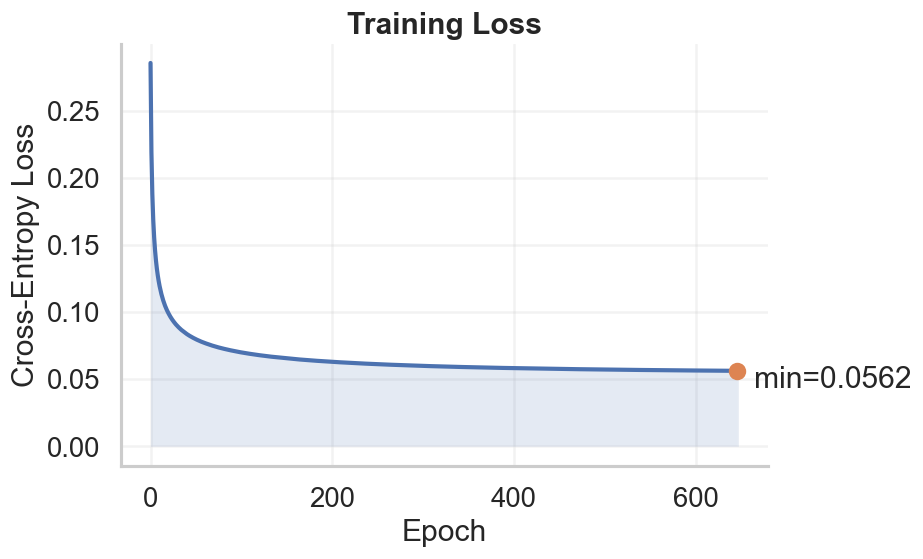

In [20]:
# Plot loss curve (nicer styling)
loss = np.array(model.loss_history, dtype=float)

fig, ax = plt.subplots()
ax.plot(loss, linewidth=2.5)
ax.fill_between(np.arange(len(loss)), loss, alpha=0.15)

best_i = int(np.argmin(loss))
ax.scatter([best_i], [loss[best_i]], s=80, zorder=3)
ax.annotate(f"min={loss[best_i]:.4f}", (best_i, loss[best_i]),
            textcoords="offset points", xytext=(10, -10))

ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
fig.tight_layout()
plt.show()

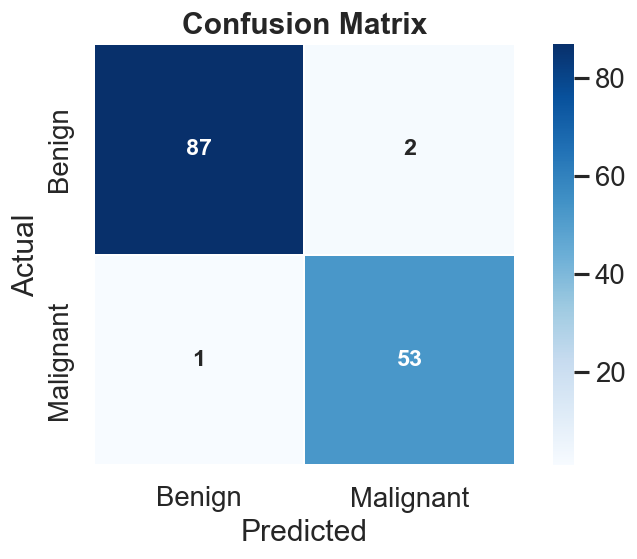

In [21]:
# Confusion matrix (prettier)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_np, pred)
labels = ["Benign", "Malignant"]

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    square=True,
    linewidths=1,
    linecolor="white",
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"fontsize": 14, "fontweight": "bold"},
    ax=ax,
)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
fig.tight_layout()
plt.show()

#explaining the confusion matrix
#in the line sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
#here we are using seaborn's heatmap function to visualize the confusion matrix (cm)
#annot=true... means we want to annot the heatmap with the actual numbers from the confusion matrix
#fmt = 'd' means we want to format the annotations as integers
#cmap='Blues' specifies the color map to use for the heatmap
#xticklabels and yticklabels set the labels for the x and y axes respectively
#this visualization helps us see how many benign and malignant cases were correctly and incorrectly classified by the model


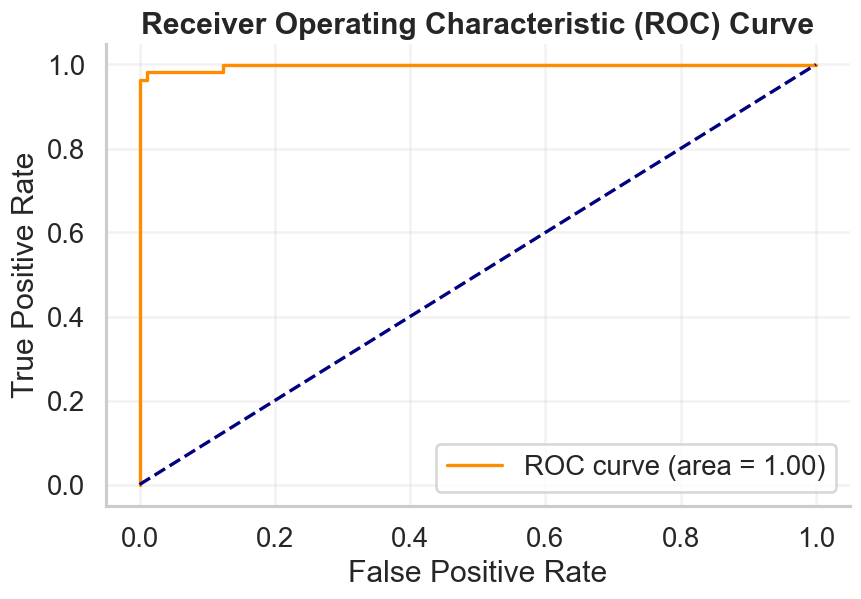

In [22]:
#plotting efficiency curve (ROC curve)
from sklearn.metrics import roc_curve, auc
y_scores = model.predict_proba(X_test_scaled)
false_positive_Rates, true_positive_Rates, thresholds = roc_curve(y_test_np, y_scores)
roc_auc = auc(false_positive_Rates, true_positive_Rates)
plt.figure()
plt.plot(false_positive_Rates, true_positive_Rates, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

#Explanation: will do each line
#from sklearn.metrics import roc_curve, auc we are importing the roc_curve and auc functions from sklearn.metrics

#then y_scores = mode.predict_proba(X_test_scaled) we are getting the predicted probabilities for the positive class (malignant) using our trained model

#then false_positive_Rates, true_positive_Rates, thresholds = roc_curve(y_test_np, y_scores) we are computing the ROC curve using y_test_np (true labels) and y_scores (predicted probabilities)

#this function returns the false positive rates, true positive rates, and thresholds

#then roc_auc = auc(false_positive_Rates, true_positive_Rates) we are calculating the area under the ROC curve (AUC) using the false positive rates and true positive rates
#then we are plotting the ROC curve using matplotlib

#plt.plot(false_positive_Rates, true_positive_Rates, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') this line plots the ROC curve

#here we have labeled the curve with the AUC value for reference lw=2 sets the line width, and color='darkorange' sets the line color and area under the curve (AUC) is a measure of the model's ability to distinguish between classes , here :.2f formats the AUC value to 2 decimal places

#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') this line plots a diagonal dashed line representing a random classifier, 
#this dashed line serves as a baseline for comparison

#then we are setting the usual title and labels for the plot and displaying the legend

